In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy import linalg
from numba import njit

On considére dans ce cas l'équation de Burgers avec diffusion non linéaire suivante:
\begin{equation}
    \begin{cases}
    & \frac{\partial u}{\partial t} +  \frac{\partial u^2}{\partial x} = \frac{\partial}{\partial x}\left( \left( \mu + \frac{\tau_y}{\sqrt{\epsilon^2 + (\partial_x u)^2}} \right) \frac{\partial u}{\partial x} \right)+f(x,t) \quad \text{pour} \quad t > 0, \quad x \in [l, L] \\
    & u(x,0)=u_0(x) \quad \forall x \in [l,L]
    \end{cases}
\end{equation}

<span style="color:red;">Premier cas:</span>

La solution exacte:
$$
u(x,t)=\alpha e^{-2\beta t} sin(2\pi x)
$$
$$ \Longrightarrow{} u_t = -2\alpha \beta e^{-2\beta t}sin(2\pi x)=-2\beta u$$
et 
$$ u_x = 2 \pi \alpha e^{-2 \beta t} cos(2\pi x)$$
et 
$$\frac{\partial}{\partial x}\left( \left( \mu + \frac{\tau_y}{\sqrt{\epsilon^2 + (\frac{\partial u}{\partial x})^2}} \right) \frac{\partial u}{\partial x} \right)=\frac{8\tau_y \pi^3 \alpha e^{-2\beta t}\cos(2\pi x) u}{\left( \epsilon^2 + \left(2\pi \alpha e^{-2\beta t}\cos(2\pi x)\right)^2 \right)^{\frac{3}{2}}}...
$$
Par suite:
\begin{align}
f(x,t) & = u_t+uu_x-\epsilon \frac{\partial }{\partial x} ( |u_x|^p u_x) \\
&= -2\beta u  + 2 u \pi \alpha e^{-2 \beta t} cos(2\pi x)...
\end{align}

<span style="color:red;">Deuxieme cas:</span>
$$ 
u(t, x) = 
\begin{cases} 
tx & \text{if } 0 \leq x \leq 1 \\
t & \text{if } 1 \leq x \leq 3 \\
t(4 - x) & \text{if } 3 \leq x \leq 4
\end{cases}
$$
Ce qui implique:
$$ 
u_t = 
\begin{cases} 
x & \text{if } 0 \leq x \leq 1 \\
1 & \text{if } 1 \leq x \leq 3 \\
(4-x)  & \text{if } 3 \leq x \leq 4
\end{cases}
$$
$$ 
u_x = 
\begin{cases} 
t & \text{if } 0 \leq x \leq 1 \\
0 & \text{if } 1 \leq x \leq 3 \\
-t  & \text{if } 3 \leq x \leq 4
\end{cases}
$$
et 
$$ 
 \left( \mu + \frac{\tau_y}{\sqrt{\epsilon^2 + (\frac{\partial u}{\partial x})^2}} \right) \frac{\partial u}{\partial x}  = cste \Longrightarrow{} \frac{\partial}{\partial x}\left( \left( \mu + \frac{\tau_y}{\sqrt{\epsilon^2 + (\frac{\partial u}{\partial x})^2}} \right) \frac{\partial u}{\partial x} \right)=0
$$
Par suite:
$$ 
f(x,y) = u_t+uu_x-\epsilon \frac{\partial }{\partial x} ( |u_x|^p u_x) = 
\begin{cases} 
x+ut & \text{if } 0 \leq x \leq 1 \\
1 & \text{if } 1 \leq x \leq 3 \\
4-x - ut  & \text{if } 3 \leq x \leq 4
\end{cases}
$$

In [5]:
" **** Solutions exactes proposées **** "

@njit(cache=True)
def u_exacte1(x,t, ALPHA, beta):
    return ALPHA * np.exp(-2 * beta * t) * np.sin(2 * np.pi * x)


@njit(cache=True)
def u_exacte2(x, t, ALPHA, beta):
    if x>= 0 and x<=1:
        return t*x
    elif x>1 and x<=3:
        return t
    elif x> 3:
        return t*(4-x)
    
" **** Les termes sources associés **** "

@njit(cache=True)
def f1(x, t, ALPHA, beta, epsilon,  mu ,tau):
    u  = ALPHA * np.exp(-2 * beta * t) * np.sin(2 * np.pi * x)
    term1 = -2 * beta * u
    term2 = 2 * u * np.pi * ALPHA * np.exp(-2 * beta * t) * np.cos(2 * np.pi * x)
    
    term3 = 2* np.pi * ALPHA * np.exp(-2 * beta * t) * np.cos(2 * np.pi * x)
    term4 = (4*tau*term3*np.pi**2 *u)/((epsilon**2 + term3**2)**(3/2)) * term3 - 4*np.pi**2 *(mu + tau/(np.sqrt(epsilon**2 + term3**2)))
    return term1 + term2 + term3


@njit(cache=True)
def f2(x, t, ALPHA, beta , epsilon, mu ,tau):
   
    
    if 0 <= x <= 1:
        u= t*x
    elif 1 < x <= 3:
        u= t
    else:
        u= t*(4-x)
    
    if 0 <= x <= 1:
        return x+u*t
    elif 1 < x <= 3:
        return 1
    else:
        return (4-x) -u*t
    
    
" **** Le flux exact **** "
@njit
def F(u):
    return (u**2) / 2

" **** Les flx numériques proposés **** "
@njit
def Rusanov(ug, ud, dx, dt):
    # Flux numérique Rusanov
    lamda = max(abs(ug), abs(ud))
    return 0.5 * (F(ug) + F(ud)) - lamda * (ud - ug)

@njit
def Rusanov2(ug, ud, dx, dt):
    # Deuxième version du flux numérique Rusanov
    lamda = max(abs(ug), abs(ud))
    return 0.5 * (F(ug) + F(ud) - lamda * (ud - ug))

@njit
def Roe(ug, ud, dx, dt):
    # Flux numérique Roe
    return 0.5 * ((F(ug) + F(ud)) - (ug + ud) / 2 * (ud - ug))

@njit
def LF(ug, ud, dx, dt):
    # Flux numérique Lax-Friedrichs
    return 0.5 * ((F(ug) + F(ud)) - (dx / dt) * (ud - ug))

@njit
def LFM(ug, ud, dx, dt):
    # Flux numérique Lax-Friedrichs modifié
    return 0.5 * ((F(ug) + F(ud)) - 0.5 * (dx / dt) * (ud - ug))

@njit
def LW(ug, ud, dx, dt):
    # Flux numérique Lax-Wendroff
    A = 0.5 * (ud + ug)
    return 0.5 * (F(ug) + F(ud) - (dt / dx) * A * (F(ud) - F(ug)))

@njit(cache=True)
def depature_fvc_flux(dt,alpha,x,u):
    aux=1
    eps=1e-9
    x0=0.5*(x[0]+x[1])   
    x1=x0
    xmp=x0
    while(aux>eps):
        deriv=np.interp(x0, x, u)
        x1=xmp-dt*alpha*deriv
        aux=np.abs(x0-x1)
        x0=x1
    if x0>x[1]:
        x0=x[1]
    if x0<x[0]:
        x0=x[0]    
    return x0 

 
@njit(cache=True)
def fvc_flux(u,x,dt,alpha):
    
    Alpha = alpha
    x_car = depature_fvc_flux(dt, Alpha,x,  u)

    up   = np.interp(x_car, x, u)
    

    return 0.5 * up**2
#@njit
def VFC(U0, T,  N,  alpha, epsilon, dx, CFL,X ,mu , tau, Case):
    if Case == 1:
        f = f1
    elif Case == 2:
        f=f2
        
    Un    = U0.copy()
    Unp1  = np.zeros(N)
    
    temps = 0
    

    
    while temps < T:
        absolute_differences = np.abs((np.diff(Un)/dx)**2)
        
        Diff = np.array([mu+tau/(np.sqrt(epsilon**2+absolute_differences[i])) for i in range(N-1)])
        
        max_diff = np.max(Diff)
        
        if epsilon != 0:
            dt1  = CFL * (dx/(np.max(np.abs(Un))*np.sqrt(2*alpha)))
            dt2  = CFL * 0.5 * dx**2 / np.abs(epsilon*max_diff)
            dt   = min(dt1,dt2)
        else:
            if epsilon == 0:
                dt  = CFL * dx / np.max(np.abs(Un))
                
        temps += min(dt,T-dt)
        
        for i in range(1,N-1):
            X1   = [X[i-1],X[i]]
            u1   = [Un[i-1],Un[i]]
            
            X2   = [X[i],X[i+1]]
            u2   = [Un[i],Un[i+1]]
            
            Fg  = fvc_flux(u1,X1,dt,alpha)
            Fd  = fvc_flux(u2,X2,dt,alpha)
            
            FDd = mu+tau/(np.sqrt(epsilon**2+((Un[i+1]-Un[i])/dx)**2)) * (Un[i+1]-Un[i])/dx
            FDg = mu+tau/(np.sqrt(epsilon**2+((Un[i]-Un[i-1])/dx)**2)) * (Un[i]-Un[i-1])/dx

            Unp1[i] = Un[i] - dt / dx * (Fd - Fg) +  dt/dx * (FDd-FDg) + dt * f(X[i], temps, ALPHA, beta , epsilon, mu ,tau)
            
        Unp1[0]   = Unp1[1]
        Unp1[N-1] = Unp1[N-2]
        Un = Unp1.copy()
    return Un


@njit
def Solver(U0, epsilon, T, l, L, N, CFL, scheme, mu, tau, Case):
    
    if Case == 1:
        f = f1
    elif Case == 2:
        f=f2
    

    if scheme == 0:
        flux = Roe 
    elif scheme == 1:
        flux = Rusanov
    elif scheme == 2:
        flux = Rusanov2
    elif scheme == 3:
        flux = LW
   
    
        
    Un   = U0.copy()
    Unp1 = np.zeros(N)

    temps = 0
    
    while temps < T:
        absolute_differences = np.abs((np.diff(Un)/dx)**2)
        
        Diff = np.array([mu+tau/(np.sqrt(epsilon**2+absolute_differences[i])) for i in range(N-1)])
        
        max_diff = np.max(Diff)
        
        if scheme == 0 or scheme == 2 :
            if epsilon != 0 :
                dt  = CFL /(np.max(np.abs(Un))/dx +2*np.abs(max_diff)/(dx**2))
            else:
                if epsilon == 0:
                    dt  = CFL * dx / np.max(np.abs(Un))
                
        if scheme == 1:
            if epsilon != 0 :
                dt  = CFL/(np.max(np.abs(Un))/dx +  np.abs(max_diff)/(dx**2))
            else:
                if epsilon == 0:
                    dt  = CFL * dx / np.max(np.abs(Un))
                
        if scheme == 3:
            if epsilon != 0 :
                dt  = CFL /(np.max(np.abs(Un))/dx + 2 * np.abs(max_diff)/(dx**2))
            else:
                if epsilon == 0:
                    dt  = CFL * dx / np.max(np.abs(Un))
                
            
        
        dt = min(dt, T - temps)
        temps += dt
        
        for i in range(1,N-1):
            Fd = flux(Un[i],Un[i+1],dx,dt)
            Fg = flux(Un[i-1],Un[i],dx,dt)
            FDd = mu+tau/(np.sqrt(epsilon**2+((Un[i+1]-Un[i])/dx)**2)) * (Un[i+1]-Un[i])/dx
            FDg = mu+tau/(np.sqrt(epsilon**2+((Un[i]-Un[i-1])/dx)**2)) * (Un[i]-Un[i-1])/dx

            Unp1[i] = Un[i] - dt / dx * (Fd - Fg) +  dt/dx * (FDd-FDg) + dt*f(X[i], temps, ALPHA, beta , epsilon, mu ,tau)
            
            
        Unp1[0] = Unp1[1]
        Unp1[N-1] = Unp1[N-2]


        Un[:] = Unp1[:]
        

    return Un




##############################################################################################################
Case     =  1      #premier cas / 2eme cas
T        =  0.051
l        =  0

if Case == 1:
    L = 1
    u_exacte = u_exacte1
elif Case == 2 :
    L = 4
    u_exacte = u_exacte2

epsilon  =  1e-2
N        =  101
CFL      =  1/2
alpha    =  1

beta     =  1/2
ALPHA    =  2

tau      =   2
mu       =   1e-3

X        =  np.linspace(l,L,N)
dx       =  (L-l)/(N-1)
U0       =  np.array([u_exacte(x, 0 , ALPHA, beta) for x in X])





" **** Calcul des solutions approchées **** "

results = {}

fluxes = {("Roe",0):1, ("Rusanov",1):1, ("Rusanov2",2):1, ("LW",3):1 }

for i,j in fluxes.items():  
    if j:
        results[i[0]]  =  Solver  (U0, epsilon, T, l, L, N, CFL, i[1], mu , tau, Case)   
    
U_VFC = VFC( U0, T,  N,  alpha, epsilon, dx, CFL,X ,mu , tau, Case)

results['VFC'] = U_VFC

/tmp/ipykernel_73033/219046598.py:227: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for i in range(1,N-1):
/tmp/ipykernel_73033/219046598.py:111: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'u' of function 'depature_fvc_flux'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../../../tmp/ipykernel_73033/219046598.py", line 88:
<source missing, REPL/exec in use?>

  x_car = depature_fvc_flux(dt, Alpha,x,  u)
/tmp/ipykernel_73033/219046598.py:111: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'x' of function 'depature_fvc_flux'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-li

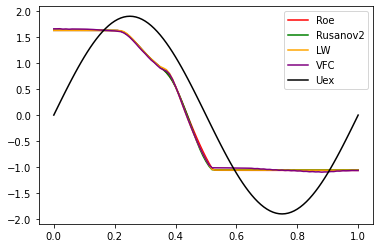

In [6]:
PLOT = {"Roe":1, "Rusanov":0, "Rusanov2":1, "LW":1, "VFC":1}

colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'brown']

for i, (flux, Un) in enumerate(results.items()) :
    k = list(PLOT)[i]
    if PLOT[k]:
        plt.plot(X, Un, '-', label=flux, color=colors[i])
    


#plt.xlim([1, 1.75])  
#plt.ylim([6, 12]) 

Uexact = np.array([u_exacte(x, T , ALPHA, beta) for x in X])
plt.plot(X, Uexact, '-k',  label='Uex')

    
plt.legend()
plt.pause(0.1)



In [10]:
Norm = {}
for i, (flux, Un) in enumerate(results.items()):
    Norm[flux]    =  np.linalg.norm(Un-Uexact,ord = 2) 
Norm


{'Roe': nan, 'VFC': 186.665974709518}